In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
class Kernel:
    """Implements a Radial Basis Function (RBF) kernel."""
    def __init__(self, gamma=0.1):
        self.gamma = gamma

    def __call__(self, x, y):
        """Calculates the kernel value between two vectors or sets of vectors."""
        x = np.asarray(x)
        y = np.asarray(y)

        if x.ndim == 1 and y.ndim == 1:
            return np.exp(-self.gamma * np.linalg.norm(x - y)**2)
        elif x.ndim == 2 and y.ndim == 2:
            # Calculate pairwise squared Euclidean distances using broadcasting
            # (x_i - y_j)^2 = x_i^2 - 2*x_i*y_j + y_j^2
            x_sq = np.sum(x**2, axis=1, keepdims=True)
            y_sq = np.sum(y**2, axis=1, keepdims=True).T
            pairwise_sq_dist = x_sq - 2 * x @ y.T + y_sq
            return np.exp(-self.gamma * pairwise_sq_dist)
        else:
            raise ValueError("Inputs to kernel must be 1D or 2D arrays.")


class TestStatistic:
    """Calculates the test statistic T_n,alpha."""
    def __init__(self, alpha=0.5, kernel=None):
        self.alpha = alpha
        # Initialize kernel here with the provided gamma
        if kernel is None:
            self.kernel = Kernel() # Default gamma if not provided
        else:
            self.kernel = kernel

    def __call__(self, X, Y):
        """
        Calculates the T_n,alpha statistic for a given set of pairs (X_i, Y_i).
        Z is a list of tuples, where each tuple is (X_i, Y_i).
        """

        n = len(X)

        # Calculate kernel matrices
        K_XX = self.kernel(X, X)
        K_XY = self.kernel(X, Y)
        K_YX = self.kernel(Y, X)
        K_YY = self.kernel(Y, Y)

        # Calculate the H matrix
        H_matrix = K_XX - K_XY - K_YX + K_YY

        # Extract the lower triangle (excluding the diagonal)
        lower_triangle_H = np.tril(H_matrix, k=-1)

        # Calculate the weights (i+1)^-alpha for i from 1 to n-1
        # The rows of the lower triangle correspond to i from 1 to n-1
        weights = (np.arange(2, n + 1).astype(float)**(-self.alpha)).reshape(-1, 1)

        # Sum the lower triangle along the columns to get Sum_{j=0 to i-1} H_ij for each i
        sum_H_j = np.sum(lower_triangle_H, axis=1)

        # The indices for sum_H_j correspond to i from 0 to n-1. We need i from 1 to n-1
        # so we take sum_H_j[1:]

        # Calculate the weighted sum
        numerator = np.sum(sum_H_j[1:] * weights.flatten())
        denominator = np.sqrt(np.sum((sum_H_j[1:] * weights.flatten())**2))


        return numerator / denominator

In [3]:
class CrossMMD:

      def __init__(self, kernel_function=None):
        # Initialize kernel here with the provided gamma
        if kernel_function is None:
            self.kernel_function = Kernel() # Default gamma if not provided
        else:
            self.kernel_function = kernel_function

      def __call__(self, X, Y):

        n, d = X.shape
        m, d_ = Y.shape
        # sanity check
        assert (d_==d) and (n>=2) and (m>=2)

        n1, m1 = n//2, m//2
        n1_, m1_ = n-n1, m-m1

        X1, X2 = X[:n1], X[n1:]
        Y1, Y2 = Y[:m1], Y[m1:]

        Kxx = self.kernel_function(X1, X2)
        Kyy = self.kernel_function(Y1, Y2)

        Kxy = self.kernel_function(X1, Y2)
        Kyx = self.kernel_function(Y1, X2)

        # compute the numerator
        Ux = Kxx.mean() - Kxy.mean()
        Uy = Kyx.mean() - Kyy.mean()
        U = Ux - Uy
        # compute the denominator
        term1 = (Kxx.mean(axis=1) - Kxy.mean(axis=1) - Ux)**2
        sigX2 = term1.mean()
        term2 = (Kyx.mean(axis=1) - Kyy.mean(axis=1) - Uy)**2
        sigY2 = term2.mean()
        sig = np.sqrt(sigX2/n1 + sigY2/m1)
        if not sig>0:
          print(f'term1={term1}, term2={term2}, sigX2={sigX2}, sigY2={sigY2}')
          raise Exception(f'The denominator is {sig}')
        # obtain the statistic
        T = U/sig
        return T



In [4]:
class LMMD:
    """Calculates the test statistic T_n,alpha."""
    def __init__(self, kernel=None):
        # Initialize kernel here with the provided gamma
        if kernel is None:
            self.kernel = Kernel() # Default gamma if not provided
        else:
            self.kernel = kernel

    def __call__(self, X, Y):
        """
        Calculates the self-normalized statistic from the vector H[2i-1, 2i].
        """

        n = len(X)

        # Calculate kernel matrices
        K_XX = self.kernel(X, X)
        K_XY = self.kernel(X, Y)
        K_YX = self.kernel(Y, X)
        K_YY = self.kernel(Y, Y)

        # Calculate the H matrix
        H_matrix = K_XX - K_XY - K_YX + K_YY

        # Extract the elements H[2i-1, 2i] for i from 1 to n/2
        # The range should be up to n // 2 (exclusive of n // 2 + 1)
        h_values = np.array([H_matrix[2*i, 2*i + 1] for i in range(n // 2)])

        # Calculate the sum and standard deviation
        mean_h = np.mean(h_values)
        std_h = np.sqrt(np.mean(h_values**2))

        return np.sqrt(len(h_values))*mean_h/std_h

In [5]:
class BTest:
    def __init__(self, kernel_function, B=None): # Modified to require a kernel
        self.kernel_function = kernel_function
        self.B = B

    def _h_function(self, K_xx, K_yy, K_xy, K_yx):
        return K_xx + K_yy - K_xy - K_yx

    def __call__(self, X, Y):
        n, d = X.shape
        if n != len(Y):
            raise ValueError("Samples X and Y must have the same number of observations.")

        B = self.B if self.B is not None else int(np.sqrt(n))
        if B < 2 or B > n:
            raise ValueError("Block size B must be between 2 and the number of samples.")

        num_blocks = n // B

        K_xx = self.kernel_function(X, X)
        K_yy = self.kernel_function(Y, Y)
        K_xy = self.kernel_function(X, Y)
        h_matrix = self._h_function(K_xx, K_yy, K_xy, K_xy.T)

        block_mmds = np.zeros(num_blocks)

        for i in range(num_blocks):
            start = i * B
            end = start + B
            h_block = h_matrix[start:end, start:end]
            sum_off_diagonal = np.sum(h_block) - np.trace(h_block)
            block_mmds[i] = sum_off_diagonal / (B * (B - 1))

        eta_k_hat = np.mean(block_mmds)
        var_eta_k_hat = np.var(block_mmds, ddof=1) / num_blocks

        if var_eta_k_hat <= 0:
            return 0.0

        test_statistic = eta_k_hat / np.sqrt(var_eta_k_hat)
        return test_statistic

In [6]:
from scipy.stats import norm

def run_tests(X, Y, alpha=0.5, gamma=0.1, B = 10):
    """
    Computes the p-values for TestStatistic and LMMD using a Gaussian threshold.
    """

    test_statistic = TestStatistic(alpha=alpha, kernel=Kernel(gamma=gamma))
    lmmd = LMMD(kernel=Kernel(gamma=gamma))
    B_test = BTest(kernel_function=Kernel(gamma=gamma), B=B)
    cross_mmd = CrossMMD(kernel_function=Kernel(gamma=gamma))

    # Calculate the observed statistics
    T_observed = test_statistic(X, Y)
    LMMD_observed = lmmd(X, Y)
    B_observed = B_test(X, Y)
    cross_mmd_observed = cross_mmd(X, Y)

    # Calculate p-values using the absolute value and the Gaussian threshold (CDF of standard normal)
    p_value_T = (1 - norm.cdf(T_observed))
    p_value_LMMD = (1 - norm.cdf(LMMD_observed))
    p_value_B = (1 - norm.cdf(B_observed))
    p_value_cross_mmd = (1 - norm.cdf(cross_mmd_observed))


    return T_observed, p_value_T, LMMD_observed, p_value_LMMD, B_observed, p_value_B, cross_mmd_observed, p_value_cross_mmd

In [7]:
def run_empirical_power_experiment(alpha_value, first_digits, second_digits,
                                   significance_level = 0.05, n_sample_size=100, num_runs=100):
    """
    Runs the experiment multiple times to calculate empirical power for both tests.

    Args:
        alpha_value (float): The alpha value for the TestStatistic.
        first_digits (list): A list of digits for the first group.
        second_digits (list): A list of digits for the second group.
        n_sample_size (int): The size of the sample to draw from each group.
        num_runs (int): The number of times to run the experiment.

    Returns:
        tuple: Empirical power for TestStatistic and LMMD.
    """
    p_values_T = []
    p_values_LMMD = []
    p_values_B = []
    p_values_cross_mmd = []

    X_all = X[np.isin(y, first_digits)]
    Y_all = X[np.isin(y, second_digits)]

    # Ensure sample sizes are within bounds
    n_sample_size = min(X_all.shape[0], Y_all.shape[0], n_sample_size)


    for run in tqdm(range(num_runs)):
        # Sample n many X from first_digits and n many Y from second_digits
        X_sample = X_all[np.random.choice(X_all.shape[0], n_sample_size, replace=True)]
        Y_sample = Y_all[np.random.choice(Y_all.shape[0], n_sample_size, replace=True)]
        pooled_XY = np.concatenate((X_sample, Y_sample))

        # Compute median heuristic by computing median of pairwise distance for the pooled sample (X, Y)
        diff = pooled_XY[:, np.newaxis] - pooled_XY
        pairwise_sq_dist = np.sum(diff**2, axis=2)
        pairwise_distances_Z = np.sqrt(pairwise_sq_dist).flatten()

        non_zero_distances_Z = pairwise_distances_Z[pairwise_distances_Z > 1e-6]
        median_bandwidth_Z = np.median(non_zero_distances_Z)
        gamma_value = 1.0 / (2 * median_bandwidth_Z**2) # Common heuristic

        # Run the tests with Gaussian threshold
        T_observed, p_value_T, LMMD_observed, p_value_LMMD, B_observed, p_value_B, cross_mmd_observed, p_value_cross_mmd = run_tests(X_sample, Y_sample, alpha=alpha_value, gamma=gamma_value)
        p_values_T.append(p_value_T)
        p_values_LMMD.append(p_value_LMMD)
        p_values_B.append(p_value_B)
        p_values_cross_mmd.append(p_value_cross_mmd)

    # Calculate empirical power for both tests
    empirical_power_T = np.sum(np.array(p_values_T) < significance_level) / num_runs
    empirical_power_LMMD = np.sum(np.array(p_values_LMMD) < significance_level) / num_runs
    empirical_power_B = np.sum(np.array(p_values_B) < significance_level) / num_runs
    empirical_power_cross_mmd = np.sum(np.array(p_values_cross_mmd) < significance_level) / num_runs


    return empirical_power_T, empirical_power_LMMD, empirical_power_B, empirical_power_cross_mmd

In [8]:
# Load the MNIST dataset
print("Loading MNIST data...")
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X, y = mnist.data.astype('float32'), mnist.target.astype('int')

# Normalize pixel values
X /= 255.0

Loading MNIST data...


In [9]:
digit_group_pairs = [
    ([2, 4, 8, 9], [3, 4, 7, 9]),
    ([1, 2, 4, 8, 9], [1, 3, 4, 7, 9]),
    ([0, 1, 2, 4, 8, 9], [0, 1, 3, 4, 7, 9]),
    ([0, 1, 2, 4, 5, 8, 9], [0, 1, 3, 4, 5, 7, 9]),
    ([0, 1, 2, 4, 5, 6, 8, 9], [0, 1, 3, 4, 5, 6, 7, 9])
]

alpha_value = 1

In [10]:
# Power

np.random.seed(42)
results_mean_T = {}
results_std_T = {}
results_mean_LMMD = {}
results_std_LMMD = {}
results_mean_B = {}
results_std_B = {}
results_mean_cross_mmd = {}
results_std_cross_mmd = {}
num_outer_runs = 25 # Number of times to repeat the experiment for mean and std

print("Running empirical power experiment for different digit group pairs with alpha = 1...")
for first_digits_group, second_digits_group in digit_group_pairs:

    group_pair_key = f"Group1: {first_digits_group}, Group2: {second_digits_group}"
    results_mean_T[group_pair_key] = []
    results_std_T[group_pair_key] = []
    results_mean_LMMD[group_pair_key] = []
    results_std_LMMD[group_pair_key] = []
    results_mean_B[group_pair_key] = []
    results_std_B[group_pair_key] = []
    results_mean_cross_mmd[group_pair_key] = []
    results_std_cross_mmd[group_pair_key] = []
    print(f"\nRunning for group pair: {group_pair_key}")

    print(f"Running for alpha = {alpha_value:.2f}")
    empirical_powers_T = []
    empirical_powers_LMMD = []
    empirical_powers_B = []
    empirical_powers_cross_mmd = []
    for outer_run in range(num_outer_runs):
        power_T, power_LMMD, power_B, power_cross_mmd = run_empirical_power_experiment(alpha_value=alpha_value,
                                                             first_digits=first_digits_group,
                                                             second_digits=second_digits_group,
                                                             significance_level=0.05,
                                                             n_sample_size=100,
                                                             num_runs=100)
        empirical_powers_T.append(power_T)
        empirical_powers_LMMD.append(power_LMMD)
        empirical_powers_B.append(power_B)
        empirical_powers_cross_mmd.append(power_cross_mmd)


    mean_power_T = np.mean(empirical_powers_T)
    std_power_T = np.std(empirical_powers_T)
    results_mean_T[group_pair_key] = mean_power_T
    results_std_T[group_pair_key] = std_power_T

    mean_power_LMMD = np.mean(empirical_powers_LMMD)
    std_power_LMMD = np.std(empirical_powers_LMMD)
    results_mean_LMMD[group_pair_key] = mean_power_LMMD
    results_std_LMMD[group_pair_key] = std_power_LMMD

    mean_power_B = np.mean(empirical_powers_B)
    std_power_B = np.std(empirical_powers_B)
    results_mean_B[group_pair_key] = mean_power_B
    results_std_B[group_pair_key] = std_power_B

    mean_power_cross_mmd = np.mean(empirical_powers_cross_mmd)
    std_power_cross_mmd = np.std(empirical_powers_cross_mmd)
    results_mean_cross_mmd[group_pair_key] = mean_power_cross_mmd
    results_std_cross_mmd[group_pair_key] = std_power_cross_mmd


    print(f"Empirical Power (Mean) for TestStatistic = {mean_power_T:.4f}, Std Dev = {std_power_T:.4f}")
    print(f"Empirical Power (Mean) for LMMD = {mean_power_LMMD:.4f}, Std Dev = {std_power_LMMD:.4f}")
    print(f"Empirical Power (Mean) for B = {mean_power_B:.4f}, Std Dev = {std_power_B:.4f}")
    print(f"Empirical Power (Mean) for cross_mmd = {mean_power_cross_mmd:.4f}, Std Dev = {std_power_cross_mmd:.4f}")


print("\nEmpirical power calculations finished for all group pairs.")

Running empirical power experiment for different digit group pairs with alpha = 1...

Running for group pair: Group1: [2, 4, 8, 9], Group2: [3, 4, 7, 9]
Running for alpha = 1.00


100%|██████████| 100/100 [00:05<00:00, 18.29it/s]


Empirical Power (Mean) for TestStatistic = 1.0000, Std Dev = 0.0000
Empirical Power (Mean) for LMMD = 0.2528, Std Dev = 0.0299
Empirical Power (Mean) for B = 0.8432, Std Dev = 0.0384
Empirical Power (Mean) for cross_mmd = 0.9968, Std Dev = 0.0047

Running for group pair: Group1: [1, 2, 4, 8, 9], Group2: [1, 3, 4, 7, 9]
Running for alpha = 1.00


100%|██████████| 100/100 [00:05<00:00, 16.91it/s]


Empirical Power (Mean) for TestStatistic = 0.9468, Std Dev = 0.0201
Empirical Power (Mean) for LMMD = 0.1444, Std Dev = 0.0318
Empirical Power (Mean) for B = 0.4672, Std Dev = 0.0463
Empirical Power (Mean) for cross_mmd = 0.9156, Std Dev = 0.0265

Running for group pair: Group1: [0, 1, 2, 4, 8, 9], Group2: [0, 1, 3, 4, 7, 9]
Running for alpha = 1.00


100%|██████████| 100/100 [00:05<00:00, 18.87it/s]


Empirical Power (Mean) for TestStatistic = 0.7564, Std Dev = 0.0409
Empirical Power (Mean) for LMMD = 0.1040, Std Dev = 0.0279
Empirical Power (Mean) for B = 0.2604, Std Dev = 0.0511
Empirical Power (Mean) for cross_mmd = 0.7476, Std Dev = 0.0388

Running for group pair: Group1: [0, 1, 2, 4, 5, 8, 9], Group2: [0, 1, 3, 4, 5, 7, 9]
Running for alpha = 1.00


100%|██████████| 100/100 [00:05<00:00, 18.81it/s]


Empirical Power (Mean) for TestStatistic = 0.6128, Std Dev = 0.0485
Empirical Power (Mean) for LMMD = 0.0796, Std Dev = 0.0197
Empirical Power (Mean) for B = 0.2004, Std Dev = 0.0357
Empirical Power (Mean) for cross_mmd = 0.6104, Std Dev = 0.0397

Running for group pair: Group1: [0, 1, 2, 4, 5, 6, 8, 9], Group2: [0, 1, 3, 4, 5, 6, 7, 9]
Running for alpha = 1.00


100%|██████████| 100/100 [00:05<00:00, 16.95it/s]

Empirical Power (Mean) for TestStatistic = 0.4436, Std Dev = 0.0586
Empirical Power (Mean) for LMMD = 0.0760, Std Dev = 0.0202
Empirical Power (Mean) for B = 0.1480, Std Dev = 0.0361
Empirical Power (Mean) for cross_mmd = 0.4760, Std Dev = 0.0543

Empirical power calculations finished for all group pairs.


In [11]:
import pickle

# Save the results
with open('power_results_mean_T.pkl', 'wb') as f:
    pickle.dump(results_mean_T, f)

with open('power_results_std_T.pkl', 'wb') as f:
    pickle.dump(results_std_T, f)

with open('power_results_mean_LMMD.pkl', 'wb') as f:
    pickle.dump(results_mean_LMMD, f)

with open('power_results_std_LMMD.pkl', 'wb') as f:
    pickle.dump(results_std_LMMD, f)

with open('power_results_mean_B.pkl', 'wb') as f:
    pickle.dump(results_mean_B, f)

with open('power_results_std_B.pkl', 'wb') as f:
    pickle.dump(results_std_B, f)

with open('power_results_mean_cross_mmd.pkl', 'wb') as f:
    pickle.dump(results_mean_cross_mmd, f)

with open('power_results_std_cross_mmd.pkl', 'wb') as f:
    pickle.dump(results_std_cross_mmd, f)

In [12]:
import pickle

# Load the results
with open('power_results_mean_T.pkl', 'rb') as f:
    loaded_results_mean_T = pickle.load(f)

with open('power_results_std_T.pkl', 'rb') as f:
    loaded_results_std_T = pickle.load(f)

with open('power_results_mean_LMMD.pkl', 'rb') as f:
    loaded_results_mean_LMMD = pickle.load(f)

with open('power_results_std_LMMD.pkl', 'rb') as f:
    loaded_results_std_LMMD = pickle.load(f)

with open('power_results_mean_B.pkl', 'rb') as f:
    loaded_results_mean_B = pickle.load(f)

with open('power_results_std_B.pkl', 'rb') as f:
    loaded_results_std_B = pickle.load(f)

with open('power_results_mean_cross_mmd.pkl', 'rb') as f:
    loaded_results_mean_cross_mmd = pickle.load(f)

with open('power_results_std_cross_mmd.pkl', 'rb') as f:
    loaded_results_std_cross_mmd = pickle.load(f)

print("Results loaded successfully.")

Results loaded successfully.


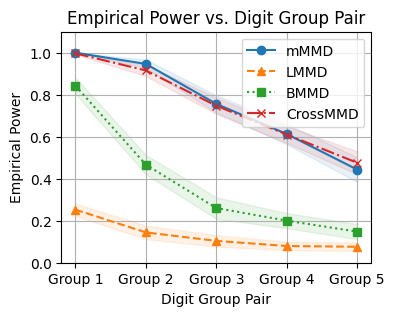

In [17]:
import matplotlib.pyplot as plt

# Prepare data for plotting
plot_data_mean_T = []
plot_data_std_T = []
plot_data_mean_LMMD = []
plot_data_std_LMMD = []
plot_data_mean_B = []
plot_data_std_B = []
plot_data_mean_cross_mmd = []
plot_data_std_cross_mmd = []


group_labels = list(loaded_results_mean_T.keys()) # Use keys from one of the loaded dictionaries
group_indices = range(len(group_labels))

for group_key in group_labels:
    plot_data_mean_T.append(loaded_results_mean_T[group_key])
    plot_data_std_T.append(loaded_results_std_T[group_key])
    plot_data_mean_LMMD.append(loaded_results_mean_LMMD[group_key])
    plot_data_std_LMMD.append(loaded_results_std_LMMD[group_key])
    plot_data_mean_B.append(loaded_results_mean_B[group_key])
    plot_data_std_B.append(loaded_results_std_B[group_key])
    plot_data_mean_cross_mmd.append(loaded_results_mean_cross_mmd[group_key])
    plot_data_std_cross_mmd.append(loaded_results_std_cross_mmd[group_key])


# Create the plot
plt.figure(figsize=(4, 3))

# Plot for TestStatistic with error band
mean_T = np.array(plot_data_mean_T)
std_T = np.array(plot_data_std_T)
plt.plot(group_indices, mean_T, marker='o', linestyle='-', label='mMMD')
plt.fill_between(group_indices, mean_T - std_T, mean_T + std_T, color='tab:blue', alpha=0.1)


# Plot for LMMD with error band
mean_LMMD = np.array(plot_data_mean_LMMD)
std_LMMD = np.array(plot_data_std_LMMD)
plt.plot(group_indices, mean_LMMD, marker='^', linestyle='--', label='LMMD', color='tab:orange')
plt.fill_between(group_indices, mean_LMMD - std_LMMD, mean_LMMD + std_LMMD, color='tab:orange', alpha=0.1)

# Plot for BTest with error band
mean_B = np.array(plot_data_mean_B)
std_B = np.array(plot_data_std_B)
plt.plot(group_indices, mean_B, marker='s', linestyle=':', label='BMMD', color='tab:green')
plt.fill_between(group_indices, mean_B - std_B, mean_B + std_B, color='tab:green', alpha=0.1)

# Plot for cross_mmd test with error band
mean_cross_mmd = np.array(plot_data_mean_cross_mmd)
std_cross_mmd = np.array(plot_data_std_cross_mmd)
plt.plot(group_indices, mean_cross_mmd, marker='x', linestyle='-.', label='CrossMMD', color='tab:red')
plt.fill_between(group_indices, mean_cross_mmd - std_cross_mmd, mean_cross_mmd + std_cross_mmd, color='tab:red', alpha=0.1)


plt.xlabel("Digit Group Pair")
plt.ylabel("Empirical Power")
plt.title("Empirical Power vs. Digit Group Pair")
plt.xticks(group_indices, [f"Group {i+1}" for i in group_indices]) # Label x-axis with Group 1, Group 2, etc.
plt.legend(loc = "upper right")
plt.grid(True)
plt.ylim(0, 1.1) # Set y-axis limits from 0 to 1.1 to accommodate potential error bands above 1

# Save the plot as a PDF
plt.savefig("empirical_power_comparison_plot.pdf", bbox_inches='tight')

plt.show()